In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd

from ex_simulation import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts, get_wavefun, dist
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_1dreconstruct, plot_wavefun

# evaluation
from matplotlib import gridspec

# load results

In [2]:
# wavelet params
wave = "sym5"
mode = "zero"
J = 4

# result path
path = opj(os.getcwd(), "results")
dirs = [wave + "_saliency_warmstart_seed=1_old"]

results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj(path, dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT1d(wave=wave, mode=mode, J=J, init_factor=1, noise_factor=0.0).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

In [3]:
# define indexes
res = results[0]
mos = models[0]
lamL1wave = np.array(res['lamL1wave'])
lamL1attr = np.array(res['lamL1attr'])
lamL1wave_grid = np.unique(lamL1wave)
lamL1attr_grid = np.unique(lamL1attr)
R = len(lamL1wave_grid)
C = len(lamL1attr_grid)

# original wavelet
wt_o = DWT1d(wave=wave, mode=mode, J=J).to(device)

# collect results
index = {}
wlist = {'psi':{},
         'wt': {},
         'dist': {}}

for r in range(R):
    for c in range(C):
        loc = (lamL1wave == lamL1wave_grid[r]) & (lamL1attr == lamL1attr_grid[c])
        if loc.sum() == 1: 
            loc = np.argwhere(loc).flatten()[0]
            index[(r,c)] = loc
            wt = mos[loc]
            _, psi, x = get_wavefun(wt)
            d = dist(wt, wt_o)
            
            wlist['wt'][(r,c)] = mos[loc]
            wlist['psi'][(r,c)] = psi
            wlist['dist'][(r,c)] = d          

# plot wavelets

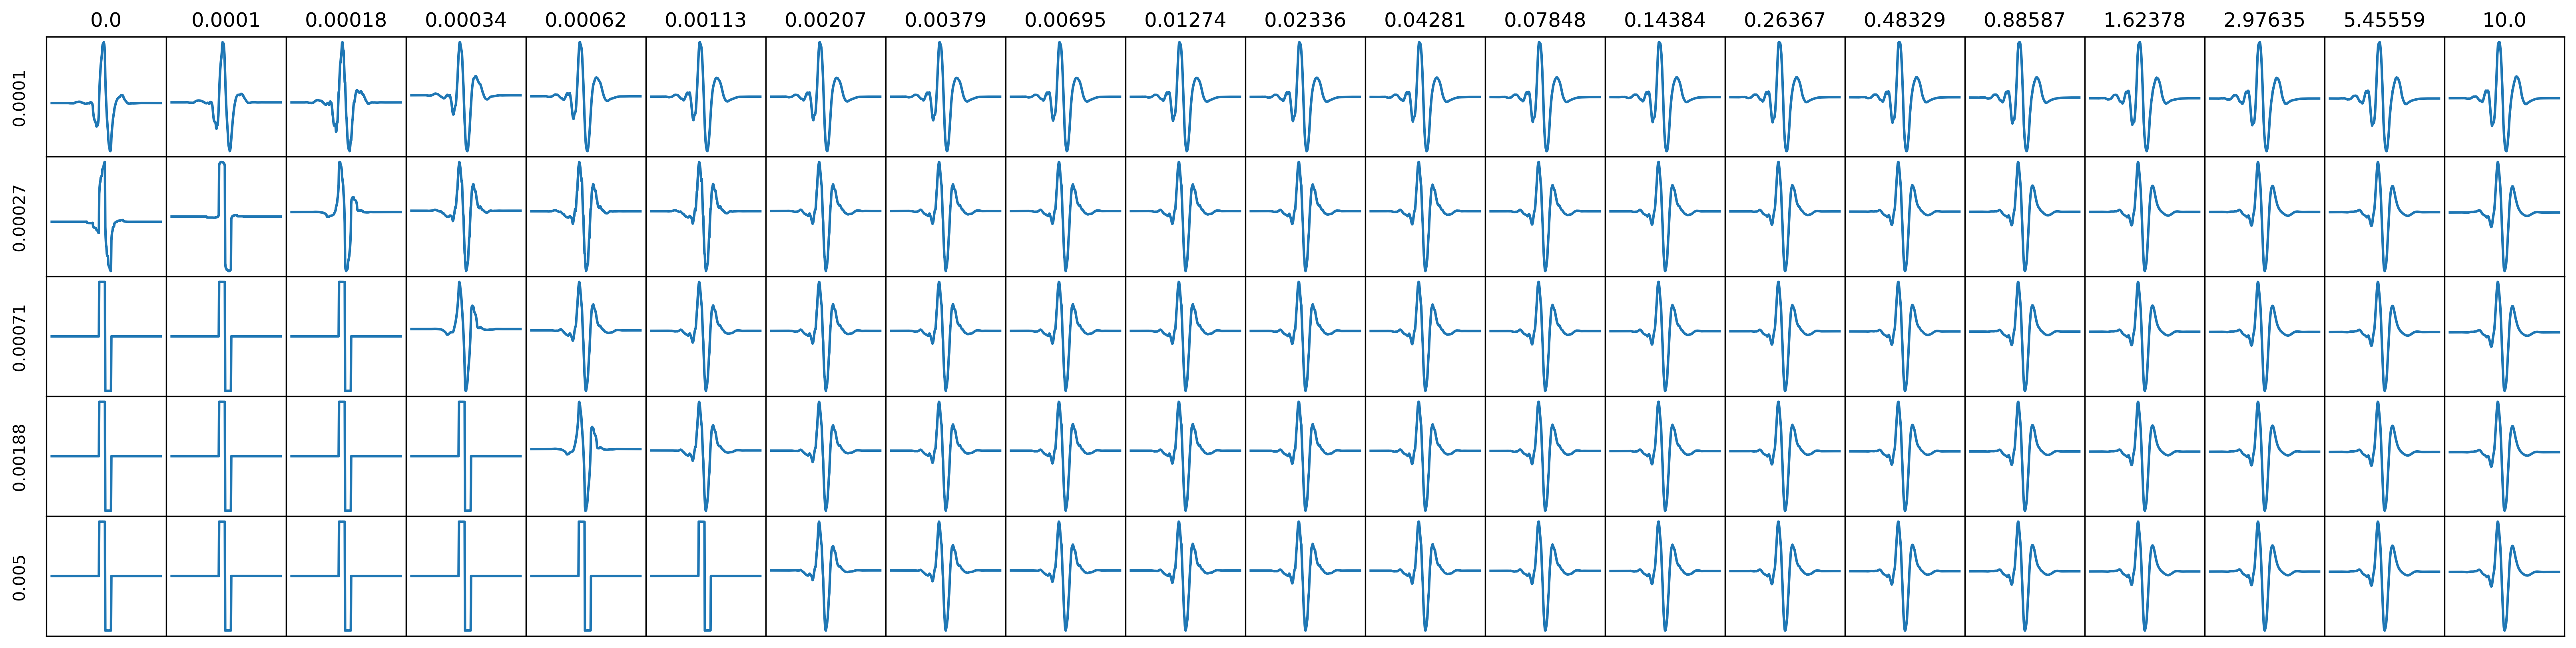

In [4]:
plt.figure(figsize=(C+1, R+1), dpi=300)
gs = gridspec.GridSpec(R, C,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(R+1), bottom=0.5/(R+1), 
         left=0.5/(C+1), right=1-0.5/(C+1))     

for r in range(R):
    for c in range(C):
        ax = plt.subplot(gs[r,c])
        ax.plot(x, wlist['psi'][(r,c)])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,
            left=False,
            right=False,
            labelbottom=False) 
        if c == 0:
            plt.ylabel(str(lamL1wave_grid[r]))
        if r == 0:
            plt.title(str(lamL1attr_grid[c]))
plt.show() 


# wavelet with min L1 distance

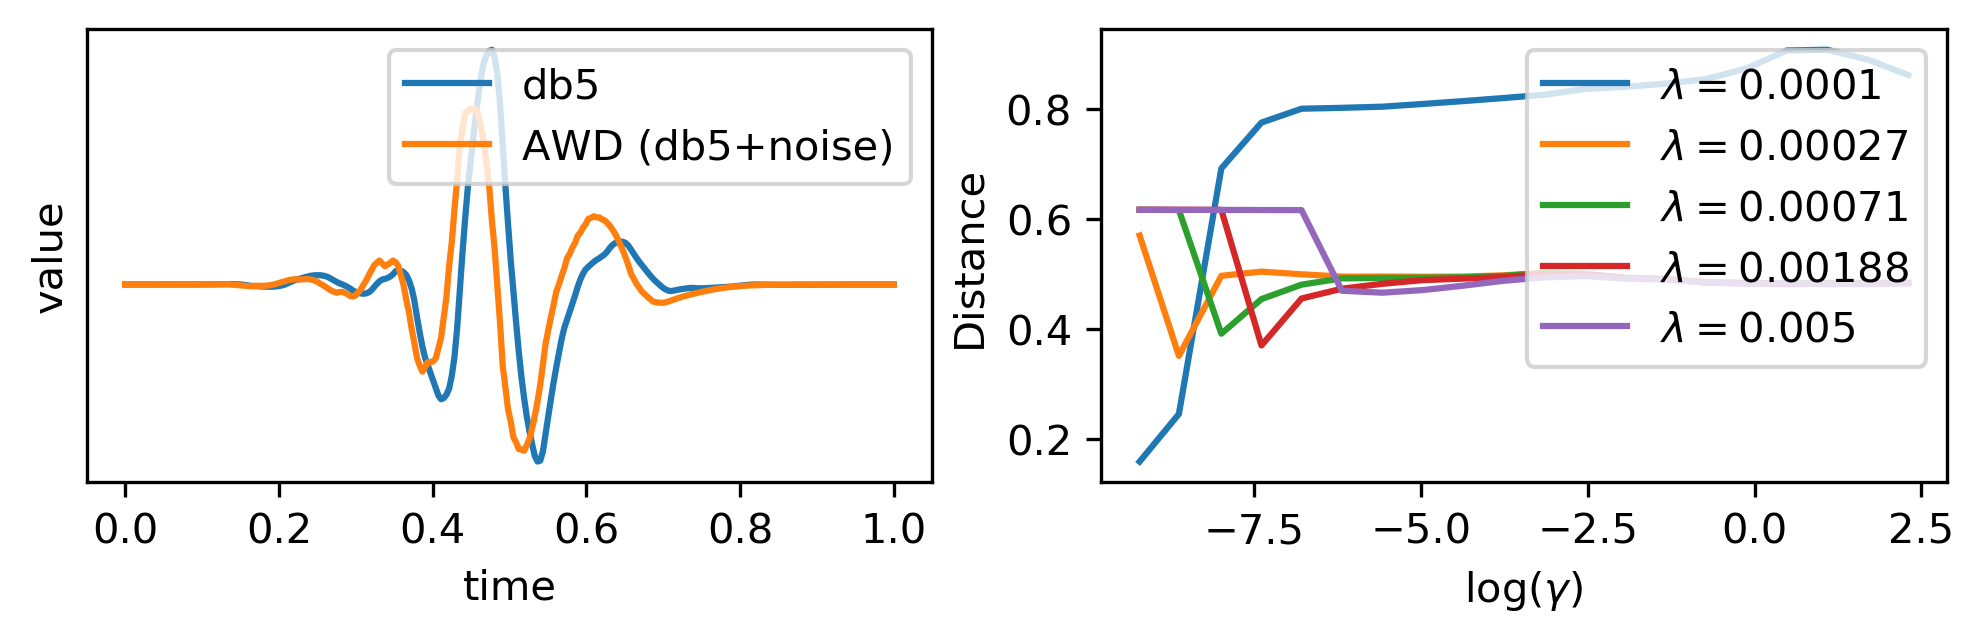

In [16]:
min_dist = min(wlist['dist'].values())
r, c = [key for key in wlist['dist'] if wlist['dist'][key] == min_dist][0]
r, c = 0, 20
wt = wlist['wt'][(r,c)]
phi, psi, x = get_wavefun(wt)
phi_o, psi_o, x_o = get_wavefun(wt_o)

fig = plt.figure(figsize=(8,2), dpi=300)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

# learned wavelet
ax0 = fig.add_subplot(spec[0, 0])
plt.plot(x/np.max(x), psi_o, label='db5')
plt.plot(x/np.max(x), psi, label='AWD (db5+noise)')
# plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_ticks([])
plt.xlabel('time')
plt.ylabel('value')  
plt.legend(loc='upper right')

# distance plot
ax1 = fig.add_subplot(spec[0, 1])
for r in range(R):
    d_array = []
    for c in range(C):
        d_array.append(wlist['dist'][(r,c)])
    plt.plot(np.log(lamL1attr_grid[1:]), d_array[1:], label='$\lambda=$'+str(lamL1wave_grid[r]))
plt.xlabel('$\log(\gamma)$')
plt.ylabel('Distance')    
plt.legend(loc='upper right')   

plt.show()
# fig.savefig("figures/figure.pdf", bbox_inches="tight", pad_inches=0.0)

In [9]:
min_dist = min(wlist['dist'].values())
r, c = [key for key in wlist['dist'] if wlist['dist'][key] == min_dist][0]
wt = wlist['wt'][(r,c)]
phi, psi, x = get_wavefun(wt)
phi_o, psi_o, x_o = get_wavefun(wt_o)

In [13]:
min_dist

0.1595878005027771

In [14]:
r

0

In [15]:
c

1